# QTL analyses of ECHO derived traits in JAX CR study

    Goal: to conduct GxEMM heritabilty and linkage mapping analysis of ECHO traits

In [23]:
### import packages

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#%load_ext autoreload
#%autoreload 2

import re, os, csv, pdb, sys, warnings
sys.path.append('/home/wright/')
warnings.filterwarnings('ignore')

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plot
from sklearn.linear_model import LinearRegression
from statsmodels.stats import multitest
import pybedtools
pybedtools.helpers.set_bedtools_path(path='/home/anil/software/miniconda3/bin/')
#from qvalue.qvalue import qvalue
import pysam
import pickle
import subprocess
import time
import sqlite3
import pandas as pd

##import mouse gff file
gene_conn = sqlite3.connect("/group/diversity_outcross/genetics/jax/geno_data_raw/mouse_genes_mgi.sqlite")
gene_db = gene_conn.cursor()
gene_db.execute("PRAGMA table_info(genes)")
gene_columns = [column for column in gene_db]
#print([c[1] for c in gene_columns])

##import all snp variants from collaborative cross
variant_conn = sqlite3.connect("/group/diversity_outcross/genetics/jax/geno_data_raw/cc_variants.sqlite")
variant_db = variant_conn.cursor()
variant_db.execute("PRAGMA table_info(variants)")
variant_columns = [column for column in variant_db]

##import tools from do_qtl package
from do_qtl.lib.models import gxemm
from do_qtl.lib import data_io as io


In [2]:
DIETS = ['AL', '20', '40', '1D', '2D']
DIET_COLORS =  ['grey', 'lightblue', 'blue', 'orange', 'darkorange']
GEN_WAVE = ['G22W1'] #12 genwaves in total


## 1. Load Pheno, Covariate, & Kinship Files


In [30]:
########## edit phenotypes, yr1, 2, 2-1
working_dir = "/home/wright/do_qtl/echo/"
#pheno_yr123_file = working_dir+"Echo_Processed_BatchBWAdjusted_20201123.csv"
pheno_yr123_file = working_dir+"Echo_Processed_BatchAdjusted_20201123.csv"
pheno_yr1_file = working_dir+"echo_batch.adj_20201123.yr1.csv"
pheno_yr2_file = working_dir+"echo_batch.adj_20201123.yr2.csv"
pheno_yr3_file = working_dir+"echo_batch.adj_20201123.yr3.csv"

df = pd.read_csv(pheno_yr123_file)
df1 = df[df['Timepoint'] == '10 months']
df1.to_csv(pheno_yr1_file, header=True, sep=",", index=False)

df2 = df[df['Timepoint'] == '22 months']
df2.to_csv(pheno_yr2_file, header=True, sep=",", index=False)

df3 = df[df['Timepoint'] == '34 months']
df3.to_csv(pheno_yr3_file, header=True, sep=",", index=False)


In [31]:
########## load pheno
working_dir = "/home/wright/do_qtl/echo/"
phenotype_file = pheno_yr1_file

phenotype_name = "CardiacOutput"
phenotype = io.Phenotype()
phenotype.load(phenotype_file, phenotype_name)
print(phenotype.all_samples[:5])

['DO-AL-0001', 'DO-20-1001', 'DO-40-2001', 'DO-1D-3001', 'DO-2D-4001']


In [32]:
# load diet covariates 
covar_dir = "/group/diversity_outcross/nonmetabolic_cage/jax/"
diet_covariate_file = covar_dir+"diet_covariates.csv"
diet_covariate = io.Covariate(test_gxe=True, effect='fixed', gxe=True) #test_gxe=True -- we will test for interaction between kinship x diet
diet_covariate.load(diet_covariate_file)
print(diet_covariate.names)

# load generation covariates
gen_covariate_file = covar_dir+"generation_covariates.csv"
gen_covariate = io.Covariate(test_gxe=False, effect='fixed', gxe=True) #test_gxe=False -- do not test for interaction between kinship x diet
gen_covariate.load(gen_covariate_file)
print(gen_covariate.names)

# store all covariate objects as a list
covariates = [diet_covariate, gen_covariate]
print(len(gen_covariate.data))

['AL', '20', '40', '1D', '2D']
['G22W1', 'G22W2', 'G23W1', 'G23W2', 'G24W1', 'G24W2', 'G26W1', 'G26W2', 'G27W1', 'G27W2', 'G28W1', 'G28W2']
960


In [33]:
# load kinship
genetics_dir = "/group/diversity_outcross/genetics/jax/geno_data_proc/"
kinship_file = genetics_dir+"kinship_matrix.genoprob.csv" ##double check with Anil - from genotypes or genoprobs?

genotype = io.Genotype()
genotype.load_kinship(kinship_file)

## 2. Run Analysis - calc PVE

In [39]:
# subset to common samples
io.intersect_datasets(genotype, phenotype, covariates)
print(genotype.N_samples)

886


In [35]:
### subset number of samples. helps when testing code
df = pd.read_csv(diet_covariate_file)
#print(df.head(n=2))
test_samples = df['mouse_id'].tolist()
print(len(test_samples))
x = 4
test_samples = test_samples[::x] ##take every x sample -- ie every 4th
print(len(test_samples))
# subset to common samples
#io.intersect_datasets(genotype, phenotype, covariates, at_samples=test_samples)
#print(genotype.N_samples)

960
240
221


In [ ]:
# fit the model
model = gxemm.Gxemm(genotype.kinship,
                    phenotype.data,
                    covariates)

# set get_serr=True, if you want to compute
# the standard error of the PVE estimate
model.fit_pve(get_serr=True)

In [38]:
##print
print(model.sigma)  # noise terms, first is shared noise. gene x diet -- whatever gxe_test=True. often sigma can be zero
print(model.omega)  # diet + gen specific noise, Var_Err . this can often be high, and diet specific. leading to large deviations from gxemm and emma.
print(model.rho)    # additive variance --- emma total variance result

# output PVE results
print("Total PVE = %.4f; Std. err = %.4f"%(model.total_pve, model.total_pve_serr))
#print("Total PVE = %.4f; "%(model.total_pve))

# the first 5 entries in model.pve contain
# the PVE of body weight in each dietary context
for diet, p, p_se in zip(diet_covariate.names, model.pve, model.pve_serr):
  print("PVE in %s diet = %.4f; Std. err = %.4f"%(diet, p, p_se))

#for diet, p in zip(diet_covariate.names, model.pve):
#  print("PVE in %s diet = %.4f"%(diet, p))

[1.00000000e-12 7.15519136e+06 7.84720899e+06 1.00000000e-12
 1.13491787e+07 2.51753737e+07 1.00000000e-12 1.85812665e+07
 1.46842060e+07 1.52280300e+07 1.35658392e+07 2.04475024e+07
 9.74013234e+06 9.57602202e+06 2.05181064e+07 9.93911912e+06
 4.91744216e+06 2.29777558e+07]
[1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12
 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12]
[1.e-12]
Total PVE = 0.0000; Std. err = 0.0743
PVE in AL diet = 0.0000; Std. err = 0.1062
PVE in 20 diet = 0.0000; Std. err = 0.0810
PVE in 40 diet = 0.0000; Std. err = 0.0998
PVE in 1D diet = 0.0000; Std. err = 0.0654
PVE in 2D diet = 0.0000; Std. err = 0.0546


## 3. Run GWAS + Estimate Effects

In [46]:
genetics_dir = "/group/diversity_outcross/genetics/jax/geno_data_proc/"

working_dir = "/home/wright/do_qtl/echo/"
script_dir = "/home/wright/do_qtl/analysis/"
log_dir = working_dir+"logs/"

chrm_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'X']
chrm_list = ['15','19']

phenotype_file = pheno_yr1_file
phenotype = "CardiacOutput"
covar_dir = "/group/diversity_outcross/nonmetabolic_cage/jax/"
covar_diet = covar_dir+"diet_covariates.csv"
covar_gen = covar_dir+"generation_covariates.csv"

for chrm in chrm_list:
    genotype_file = genetics_dir+"prob.8state.allele.qtl2_200131.Rdata."+chrm+".csv"
    log_file = log_dir+"qtl_chrm"+chrm+"_"+phenotype+".log"
    script_gwas = script_dir+"run_gwa_analysis.py"
    sbatch_script = script_gwas+"_"+chrm+".sh"
    fOUT = open(sbatch_script, 'w')
    print ("#!/bin/bash", file=fOUT)
    print ("#SBATCH --cpus-per-task=1", file=fOUT)
    print ("#SBATCH --ntasks-per-node=1", file=fOUT) 
    print ("#SBATCH --mem-per-cpu=5400", file=fOUT)
    print ( "#SBATCH --job-name=qtl_gxemm", file=fOUT)
    print ( "#SBATCH --partition=standard", file=fOUT)
    print ( "#SBATCH --output="+log_file, file=fOUT)
    print ( "#SBATCH --error="+log_file+".err", file=fOUT)

    print ( "source activate mypython3", file=fOUT)
    print ( "python "+script_gwas+" --chromosome "+chrm+" --genotype_file "+genotype_file + \
           " --phenotype_file "+phenotype_file+ " --phenotype "+phenotype+ \
           " --covar_diet_file "+covar_diet + " --covar_gen_file "+covar_gen, file=fOUT)
    
    fOUT.close()
    !ssh wright@cb "cd {working_dir}; sbatch {sbatch_script} "
    
    ##submit gwas effect estiamtes
    log_file = log_dir+"effects_chrm"+chrm+"_"+phenotype+".log"
    script_effects = script_dir+"run_gxemm_effects.py"
    sbatch_script = script_gwas+"_"+chrm+".sh"
    fOUT = open(sbatch_script, 'w')
    print ("#!/bin/bash", file=fOUT)
    print ("#SBATCH --cpus-per-task=1", file=fOUT)
    print ("#SBATCH --ntasks-per-node=1", file=fOUT) 
    print ("#SBATCH --mem-per-cpu=5400", file=fOUT)
    print ( "#SBATCH --job-name=effect_gxemm", file=fOUT)
    print ( "#SBATCH --partition=standard", file=fOUT)
    print ( "#SBATCH --output="+log_file, file=fOUT)
    print ( "#SBATCH --error="+log_file+".err", file=fOUT)

    print ( "source activate mypython3", file=fOUT)
    print ( "python "+script_effects+" --chromosome "+chrm+" --genotype_file "+genotype_file + \
           " --phenotype_file "+phenotype_file+ " --phenotype "+phenotype+ \
           " --covar_diet_file "+covar_diet + " --covar_gen_file "+covar_gen, file=fOUT)
    
    fOUT.close()
    !ssh wright@cb "cd {working_dir}; sbatch {sbatch_script} "
    print (log_file)
    

Submitted batch job 22384744
Submitted batch job 22384745
/home/wright/do_qtl/echo/logs/effects_chrm15_CardiacOutput.log
Submitted batch job 22384746
Submitted batch job 22384747
/home/wright/do_qtl/echo/logs/effects_chrm19_CardiacOutput.log


In [47]:
print (log_file)
#log_file = "/home/wright/do_mice/qtl_lifespan_gxemm/logs/gxemm_chrm18.qtl.log"
!ssh cb "squeue -u wright"
!ssh cb "head -n 4000 {log_file}"
!ssh cb "head -n 400 {log_file}.err"

/home/wright/do_qtl/echo/logs/effects_chrm19_CardiacOutput.log
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          22352760  standard subset_v   wright  R    8:19:17      1 n0044
          22352762  standard subset_v   wright  R    8:19:17      1 n0045
          22352759  standard subset_v   wright  R    8:19:20      1 n0012
/home/wright/do_qtl/echo/echo_batch.adj_20201123.yr1.csv CardiacOutput 19 /group/diversity_outcross/genetics/jax/geno_data_proc/prob.8state.allele.qtl2_200131.Rdata.19.csv /group/diversity_outcross/nonmetabolic_cage/jax/diet_covariates.csv /group/diversity_outcross/nonmetabolic_cage/jax/generation_covariates.csv
['AL', '20', '40', '1D', '2D']
['G22W1', 'G22W2', 'G23W1', 'G23W2', 'G24W1', 'G24W2', 'G26W1', 'G26W2', 'G27W1', 'G27W2', 'G28W1', 'G28W2']
n samples 0
/home/wright/do_qtl/echo/effects_output.CardiacOutput.19.csv
['variant.id', 'additive.LOD', 'additive.p.value', 'additive.intercept', 'additive.effect.size.A', 'add

## 5. Run Fine Mapping 

In [23]:
working_dir = "/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/"
output_dir = "/home/wright/do_mice/qtl_lifespan_gxemm/"
script_dir = "/home/wright/diversity_outcross/analysis/qtl/"
log_dir = output_dir+"logs/"

script_file = script_dir+"run_finemap_genoprob_analysis_ls.py" 
sbatch_script = script_file+".sh"

sigloci_dict = {
            '16':['4000000','13500000'],
            '1':['2000000','4000000'],    ##st & end in bp, not Mb
            '6':['98000000','108000000'], 
            '9':['11000000','18000000'], 
            '14':['107000000','121000000'], 
            '18':['15000000','25000000']
            }
model = 'gxe' #'emma'
phenotype = 'Lifespan.Zsc'
#focal_pop = 'jac'
focal_pop = 'all'

#input files
if focal_pop == 'all':
    phenotype_file = working_dir+"source_data_dir/lifespan_pheno_200326.csv"
    #covar_add_file = "/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/covar_gen_200326.csv"
    covar_inter_file = "/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/covar_diet_200326.csv"
    covar_add_file = "/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/covar_gen.sty.sex_200326.csv"
    #covar_add_file = 'NA'
    covar_add = 'gen.sty.sex'
    covar_inter = 'diet'

if focal_pop == 'jac':
    phenotype_file = working_dir+"source_data_dir/lifespan_jac.csv"
    covar_add_file = working_dir+"source_data_dir/covar_gen_study_jac.csv"
    #covar_add_file = 'NA'
    covar_inter_file = working_dir+"source_data_dir/covar_sex_study_jac.csv"
    covar_add = 'gen'
    covar_inter = 'sex'
    
for chrm in sigloci_dict:
    locus_st = sigloci_dict[chrm][0]
    locus_end = sigloci_dict[chrm][1]
        
    output_file = output_dir+"fine_"+focal_pop+"_add.cov"+covar_add+"_int.cov"+covar_inter+"_chrm"+chrm+"."+locus_st+".csv"
    log_file = log_dir+"fine_"+focal_pop+"_add.cov"+covar_add+"_int.cov"+covar_inter+"_chrm"+chrm+"."+locus_st+".log"
    
    fOUT = open(sbatch_script, 'w')
    print ("#!/bin/bash", file=fOUT)
    print ("#SBATCH --cpus-per-task=1", file=fOUT)
    print ("#SBATCH --ntasks-per-node=1", file=fOUT) 
    print ("#SBATCH --mem-per-cpu=8400", file=fOUT)
    print ( "#SBATCH --job-name=fine_ls", file=fOUT)
    print ( "#SBATCH --partition=standard", file=fOUT)
    print ( "#SBATCH --output="+log_file, file=fOUT)
    print ( "#SBATCH --error="+log_file+".err", file=fOUT)

    print ( "source activate mypython3", file=fOUT)
    print ( "python "+script_file+" "+chrm+" "+locus_st+" "+locus_end+" "+phenotype_file+" "+phenotype+" "+covar_add_file+" "+covar_inter_file+" "+model+" "+output_file, file=fOUT)
    fOUT.close()

    !ssh wright@cb "cd {working_dir}; sbatch {sbatch_script} "
    print (log_file)

    

Submitted batch job 13907200
/home/wright/do_mice/qtl_lifespan_gxemm/logs/fine_all_add.covgen.sty.sex_int.covdiet_chrm16.4000000.log
Submitted batch job 13907201
/home/wright/do_mice/qtl_lifespan_gxemm/logs/fine_all_add.covgen.sty.sex_int.covdiet_chrm1.2000000.log
Submitted batch job 13907202
/home/wright/do_mice/qtl_lifespan_gxemm/logs/fine_all_add.covgen.sty.sex_int.covdiet_chrm6.98000000.log
Submitted batch job 13907203
/home/wright/do_mice/qtl_lifespan_gxemm/logs/fine_all_add.covgen.sty.sex_int.covdiet_chrm9.11000000.log
Submitted batch job 13907204
/home/wright/do_mice/qtl_lifespan_gxemm/logs/fine_all_add.covgen.sty.sex_int.covdiet_chrm14.107000000.log
Submitted batch job 13907205
/home/wright/do_mice/qtl_lifespan_gxemm/logs/fine_all_add.covgen.sty.sex_int.covdiet_chrm18.15000000.log


In [28]:
print (log_file)
#log_file = '/home/wright/do_mice/qtl_lifespan_gxemm/logs/lifespan_jac_chrm18.log'
!ssh cb "squeue -u wright -n fine_ls"
!ssh cb "head -n 4000 {log_file}"
!ssh cb "head -n 400 {log_file}.err"

/home/wright/do_mice/qtl_lifespan_gxemm/logs/fine_all_add.covgen.sty.sex_int.covdiet_chrm18.15000000.log
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          13907203  standard  fine_ls   wright  R       2:15      1 d03
          13907204  standard  fine_ls   wright  R       2:15      1 n0003
          13907205  standard  fine_ls   wright  R       2:15      1 n0004
          13907200  standard  fine_ls   wright  R       2:17      1 d03
          13907201  standard  fine_ls   wright  R       2:17      1 n0045
          13907202  standard  fine_ls   wright  R       2:17      1 n0002
          13907162  standard  fine_ls   wright  R       4:18      1 d02
          13907163  standard  fine_ls   wright  R       4:18      1 n0045
          13907156  standard  fine_ls   wright  R       4:20      1 d01
          13907157  standard  fine_ls   wright  R       4:20      1 d01
          13907159  standard  fine_ls   wright  R       4:20      1 d01
        

In [31]:
## Plot Fine Mapping Results
import matplotlib.pyplot as plot
import numpy as np
import scipy.stats
import pandas as pd
import os

output_dir = "/home/wright/do_mice/qtl_lifespan_gxemm/"
plot_dir = "/home/wright/do_mice/qtl_lifespan_gxemm/plots_200522/"

sigloci_dict = {
            '16':['4000000','13500000'],
            '1':['2000000','4000000'],    ##st & end in bp, not Mb
            '6':['98000000','108000000'], 
            '9':['11000000','18000000'], 
            '14':['107000000','121000000'], 
            '18':['15000000','25000000']
            }

#igloci_dict = {
#           '16':['4000000','13500000']
#

#focal_pop = 'jac'
focal_pop = 'jac'

if focal_pop == 'all':
    phenotype_file = working_dir+"source_data_dir/lifespan_pheno_200326.csv"
    covar_inter_file = "/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/covar_diet_200326.csv"
    covar_add_file = "/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/covar_gen.sty.sex_200326.csv"

    covar_add = 'gen.sty.sex'
    covar_inter = 'diet'

if focal_pop == 'jac':
    phenotype_file = working_dir+"source_data_dir/lifespan_jac.csv"
    covar_add_file = working_dir+"source_data_dir/covar_gen_study_jac.csv"

    covar_inter_file = working_dir+"source_data_dir/covar_sex_study_jac.csv"
    covar_add = 'gen'
    covar_inter = 'sex'
    

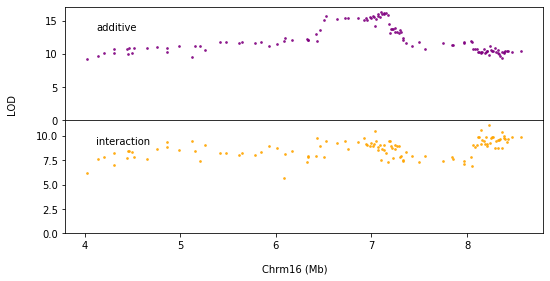

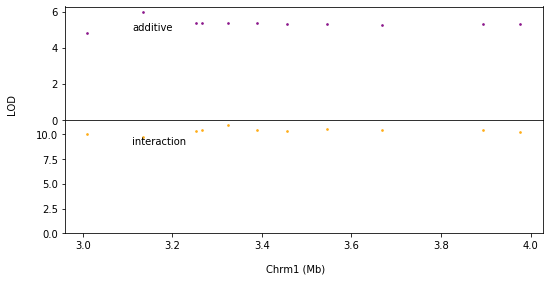

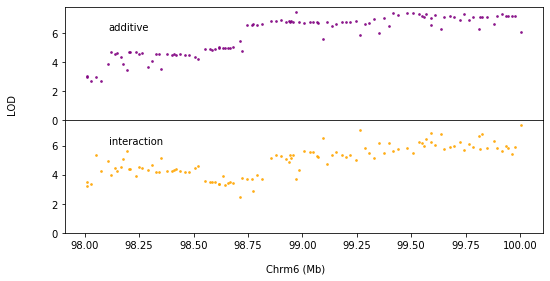

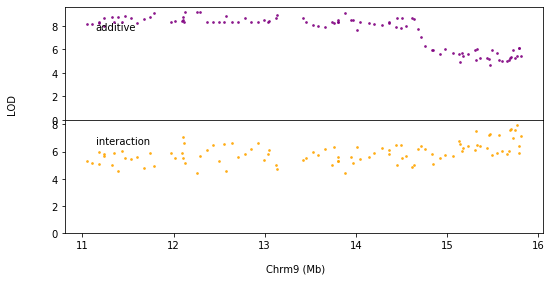

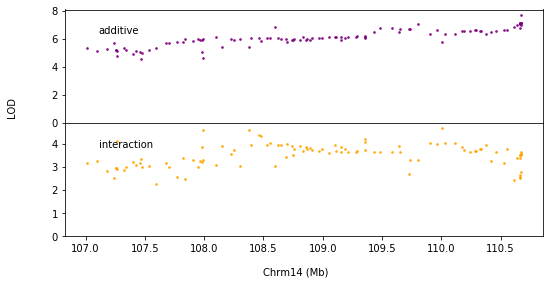

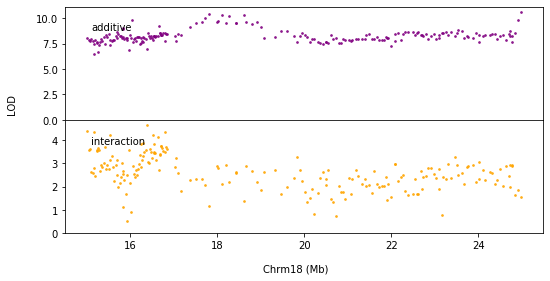

In [40]:

df_all = pd.DataFrame()
working_dir = "/home/wright/jax_cr_190429/simulation_GxEMM_200507/"

for chrm in sigloci_dict:
    locus_st = sigloci_dict[chrm][0]
    locus_end = sigloci_dict[chrm][1]
        
    output_file = output_dir+"fine_"+focal_pop+"_add.cov"+covar_add+"_int.cov"+covar_inter+"_chrm"+chrm+"."+locus_st+".csv"
    
    if os.path.isfile(output_file) is True:
        if os.stat(output_file).st_size != 0:

            df = pd.read_csv(output_file, index_col=False)
            
            figure = plot.figure(figsize=(8,4.5))
            subplots = [figure.add_axes([0.10, 0.45, 0.83, 0.35]), #xmin, ymin, dx, and dy
                        figure.add_axes([0.10, 0.10, 0.83, 0.35])]
                       
            titles = ['additive', 'interaction']
            
            subplots[0].scatter(df['location']/1e6,df['additive.LOD'],s=3, color='purple', alpha=0.8)
            subplots[1].scatter(df['location']/1e6,df['interaction.LOD'],s=3, color='orange', alpha=0.8)
            subplots[0].text(min(df['location']/1e6)+0.1, max(df['additive.LOD'])-0.1*max(df['additive.LOD']), titles[0], fontsize=10, horizontalalignment='left', verticalalignment='top')
            subplots[1].text(min(df['location']/1e6)+0.1, max(df['interaction.LOD'])-0.1*max(df['interaction.LOD']), titles[1], fontsize=10, horizontalalignment='left', verticalalignment='top')
            subplots[0].set_ylim(0,max(df['additive.LOD'])+0.05*max(df['additive.LOD']))
            subplots[1].set_ylim(0,max(df['interaction.LOD'])+0.05*max(df['interaction.LOD']))
            
            figure.text(0.5, -0.025, 'Chrm'+str(chrm)+" (Mb)", fontsize=10, horizontalalignment='center', verticalalignment='bottom')
            _ = figure.text(0., 0.5, 'LOD', fontsize=10, horizontalalignment='left', verticalalignment='center', rotation=90)
            plot.show()
            figure.savefig(plot_dir+'finemap_lod_chrm'+chrm+'.'+locus_st+'.png', dpi=400)


In [16]:
output_file

'/home/wright/do_mice/qtl_lifespan_gxemm/fine_all_add.covgen.sty.sex_int.covdiet_chrm16.4000000.csv'

In [ ]:
import matplotlib.pyplot as plot
import numpy as np
import scipy.stats

list_res_var2 = [1.0,2.0,5.0]

for res_var2_tmp in list_res_var2:

    #figure = plot.figure(figsize=(6,5))
    figure = plot.figure(figsize=(8,2.5))

    subplots = [figure.add_axes([0.10, 0.10, 0.83, 0.83])]

    titles = ['fine map']

    #for this plot - focus exclusively on simulations with 1:1 ratio in envA:envB
    df_plot = df_all[df_all['res_var2'] == res_var2_tmp] #filter to only include env_thres = 0.5
    df_plot = df_plot[df_plot['env_thres'] == 0.5]
    df1 = df_plot.groupby(['h2_true'])
    ct=0
    for idx1, grp1 in df1:
        if idx1 == 0.2 or idx1 == 0.5 or idx1 == 0.8: ##filter h2_true values to be only 0.2, 0.5, 0.8. 3 panels in plot 2B.
            df2 = grp1.groupby(['h1_true'])
            #plot
            subplots[ct].plot([0,1], [0,1], linestyle='--', linewidth=1, color='grey')
            subplots[ct].text(0.05, 0.975, titles[ct], fontsize=10, horizontalalignment='left', verticalalignment='top')

            for idx2, grp2 in df2:
                #print (ct, idx1, idx2)
                x = grp2['h1_true'].unique()
                median,lower,upper = mean_ci(grp2['gxe_h1'])
                err_diff = upper-lower
                err_center = lower+((upper-lower)/2.0)

                #plot
                #nudge=0.015
                #subplots[ct].scatter(grp2['h1_true']+nudge+0.01,grp2['gxe_h1'],s=5, edgecolor='orange', facecolor='white', alpha=0.5)
                subplots[ct].scatter(grp2['h1_true'],grp2['gxe_h1'],s=20, color='#AAAAAA', alpha=0.2)
                subplots[ct].scatter(x,median,s=100, marker='_', color='orange')
                subplots[ct].vlines(x,lower,upper, lw=1.5, color='orange')        

            ct += 1

    figure.text(0.5, -0.1, 'true h2_env1. res_var2'+str(res_var2_tmp), fontsize=10, horizontalalignment='center', verticalalignment='bottom')
    _ = figure.text(0., 0.5, 'estimated h2_env1', fontsize=10, horizontalalignment='left', verticalalignment='center', rotation=90)
    plot.show()
    figure.savefig(working_dir+'sim_gxe_3panel_res_var2'+str(res_var2_tmp)+'.png', dpi=400)
    figure.savefig(working_dir+'sim_gxe_3panel_res_var2'+str(res_var2_tmp)+'.pdf', dpi=400)

## Appendix - 1 Merge Genoprob Files from Three Studies. Create Kinship matrix in rQTL2

In [9]:
working_dir = "/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/"

data_dir = working_dir+"source_data_dir/"
script_dir = working_dir+"scripts/"
log_dir = working_dir+"logs/"

r_script = script_dir+"merge_apr_JAC_ELL_HAR_191023.r" 
sbatch_script = r_script+".sh"
#log_file = log_dir+"merge_apr_JAC_ELL_HAR_191023.log"
log_file = log_dir+"merge_apr_JAC_ELL_HAR_200514.log"

apr_jac_file = data_dir+"prob.8state_jax_shock_191218.Rdata"
apr_ell_file = data_dir+"prob.8state_ellison_191218.Rdata"
apr_har_file = data_dir+"prob.8state_harris_191218.Rdata"

pheno_file = data_dir+"combined_lifespan_hazard_191218.csv"
merge_apr = data_dir+"prob.8state_all_191218.Rdata"

#if os.path.exists(merge_apr) is False:
fOUT = open(sbatch_script, 'w')
print ("#!/bin/bash", file=fOUT)
print ("#SBATCH --cpus-per-task=4", file=fOUT)
print ("#SBATCH --ntasks-per-node=1", file=fOUT) 
print ("#SBATCH --mem-per-cpu=15400", file=fOUT)
print ( "#SBATCH --job-name=merge", file=fOUT)
print ( "#SBATCH --partition=gpu", file=fOUT)
print ( "#SBATCH --output="+log_file, file=fOUT)
print ( "#SBATCH --error="+log_file+".err", file=fOUT)

print ( "Rscript "+r_script+" "+data_dir+" "+apr_jac_file+" "+apr_ell_file+" "+apr_har_file+" "+merge_apr+" "+pheno_file, file=fOUT)
fOUT.close()

#!ssh wright@cb "cd {working_dir}; sbatch {sbatch_script} "
print (log_file)

/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/logs/merge_apr_JAC_ELL_HAR_200514.log


In [10]:
#log_file = '/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/logs/merge_apr_JAC_ELL_HAR_191023.log'
log_file = '/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/logs/merge_apr_JAC_ELL_HAR_200514.log'
#!ssh cb "squeue -u wright"
!ssh cb "head -n 4000 {log_file}"
!ssh cb "head -n 40 {log_file}.err"

[1] "input files: /home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/prob.8state_jax_shock_191218.Rdata /home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/prob.8state_ellison_191218.Rdata /home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/prob.8state_harris_191218.Rdata"
[1] "output_base: /home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/prob.8state_all_191218.Rdata"

[1] "num samples apr_jac 460"
[1] "apr_jac id post edit"
[1] "JAC_DO.0001" "JAC_DO.0002" "JAC_DO.0003" "JAC_DO.0004" "JAC_DO.0005"
[6] "JAC_DO.0006"
[1] "apr_markers"
  dimnames(apr_jac$`1`)[[3]]
1                       UNC6
2                JAX00000010
3                JAX00240603
4                JAX00240610
5                JAX00240613
6                JAX00240636

[1] "num samples apr_ell 623"
[1] "apr_ell id post edit"
[1] "ELL_9376F10.01" "ELL_9376F10.02" "ELL_9376F10.03" "ELL_9376F10.04"
[5] "ELL_9376F10.05" "ELL_9376F10.06"
[1] "apr_markers"
